Assume a 2D domain where one of the sides is exposed to a Carbon atmosphere, while two other surfaces are exposed to a Nitrogen atomosphere, while the last surface is assume to have no-flux boundary conditions

Formulate a model based on diffusion and simulate the evolution of Carbon and Nitrogen in the domain as a function of time

$$\frac{\partial u(r,t)}{\partial t} = \nabla . (D(u(r,t),r) \nabla u(r,t)$$

$$\frac{\partial u(r,t)}{\partial t} = D \nabla^2 u(r,t)$$

where 
$$\nabla u = [ \frac{\partial c}{\partial x} \frac{\partial c}{\partial y}]^T$$

$$\nabla^2 u = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}$$

if u(r,t) = u(x,y,t) then

$$\frac{\partial u}{\partial t} = \frac{u(r, t+1) - u(r,t-1)}{2\Delta T}$$


$$\frac{\partial^2 u}{\partial x^2} = \frac{  u(x+1,y,t) + u(x-1,y,t) -2u(x,y,t) }{2\Delta X}$$


$$u(t_{n+1}) = u(t_n + \Delta t)$$



$\Delta x = \Delta y$

$\alpha = \Delta t D / \Delta x^2$

$$\frac{c_{i,j}^{t+1} - c_{i,j}^t}{\Delta t} = D(\frac{c_{i+1, j}^{t+1} + c_{i-1, j}^{t+1} - 2c_{i,j}^{t+1}}{\Delta x^2} + \frac{c_{i, j+1}^{t+1} + c_{i, j-1}^{t+1} - 2c_{i,j}^{t+1}}{\Delta y^2})$$


$$c^t_{i,j} = (1 + 4\alpha) c^{t+1}_{i,j} - \alpha (c^{t+1}_{i+1,j} + c^{t+1}_{i-1,j} + c^{t+1}_{i,j+1} + c^{t+1}_{i,j-1})$$


In [1]:
# Explicit

$$\frac{c_{i,j}^{t+1} - c_{i,j}^t}{\Delta t} = D(\frac{c_{i+1, j}^t + c_{i-1, j}^t - 2c_{i,j}^t}{\Delta x^2} + \frac{c_{i, j+1}^t + c_{i, j-1}^t - 2c_{i,j}^t}{\Delta y^2})$$

$$c_i^{t+1} = (1-4\alpha)c_i^t + \alpha(c_{i+1, j}^t + c_{i-1, j}^t + c_{i, j+1}^t + c_{i, j-1}^t)$$

In [ ]:
# Crank Nicolson

$$\frac{c_{i,j}^{t+1} - c_{i,j}^t}{\Delta t} = D(\frac{c_{i+1, j}^{t+1} + c_{i-1, j}^{t+1} - 2c_{i,j}^{t+1}}{\Delta x^2} + \frac{c_{i, j+1}^{t+1} + c_{i, j-1}^{t+1} - 2c_{i,j}^{t+1}}{\Delta y^2})$$

$$\frac{c_{i,j}^{t+1} - c_{i,j}^t}{\Delta t} = D(\frac{c_{i+1, j}^t + c_{i-1, j}^t - 2c_{i,j}^t}{\Delta x^2} + \frac{c_{i, j+1}^t + c_{i, j-1}^t - 2c_{i,j}^t}{\Delta y^2})$$

$$\frac{c_{i,j}^{t+1} - c_{i,j}^t}{\Delta t} = (D/2)(\frac{c_{i+1, j}^t + c_{i-1, j}^t - 2c_{i,j}^t}{\Delta x^2} + \frac{c_{i, j+1}^t + c_{i, j-1}^t - 2c_{i,j}^t}{\Delta y^2} + \frac{c_{i+1, j}^{t+1} + c_{i-1, j}^{t+1} - 2c_{i,j}^{t+1}}{\Delta x^2} + \frac{c_{i, j+1}^{t+1} + c_{i, j-1}^{t+1} - 2c_{i,j}^{t+1}}{\Delta y^2})$$


In [ ]:
# Taylor Series

$f(x) = f(a) + (x-a) f'(a) + O(x^2)$

$$u(r,t+\Delta t) = u(r,t) + \Delta t \frac{\partial u(r,t)}{\partial t}$$

$$u(r,t) = u(r,t+\Delta t) + (-\Delta t) \frac{\partial u(r,t+\Delta t)}{\partial t}$$

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
from tqdm import tqdm

In [3]:
# Some grid that goes 0 to N+1 on both sides
# the actual values will be calculated 1 to N
# grid(i,j)
#j=0 is the left wall
# i=0 is the top wall

In [36]:
N = 50
delta_x = 0.1
delta_t = 0.05
timesteps = 100
D = 5
alpha = delta_t * D / delta_x

In [37]:
grid = np.zeros((N+2,N+2, timesteps))

In [38]:
grid[:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
def flatten_index(i,j, col=None):
    if col is None:
        col = N
    return (i-1)*col + (j-1)
    # grid is (N+2,N+2), the A has to be (N^2, N^2)
def unflatten_index(ind, col=None):
    if col is None:
        col = N+2
    i = ind//col
    j = ind%col
    return (i,j)

In [40]:
for i in range(N+2):
    grid[N+1,i] = 1

In [41]:


def create_A():
    A = np.zeros((N*N, N*N))

    for i in range(1, N+1): # will run 1 to N, so i-1 will be 0 to N-1
        for j in range(1, N+1):

            center = flatten_index(i, j)

            # main diagonal
            A[center, center] = 1 + 4*alpha

            # neighbors
            if i > 1:      # up
                A[center, flatten_index(i-1, j)] = -alpha
            if i < N:      # down
                A[center, flatten_index(i+1, j)] = -alpha
            if j > 1:      # left
                A[center, flatten_index(i, j-1)] = -alpha
            if j < N:      # right
                A[center, flatten_index(i, j+1)] = -alpha

    return A


def impose_boundary_condition(A,b): #NxN
    initial_value=1
    initial_value_2 = 0
    for row in range(1,N+1):
        for col in range(1,N+1):
            i = row
            j = col
            if row == 1: # neumann
                up = flatten_index(i-1,j)
                center = flatten_index(i,j)
                A[center,center] -= alpha
            if row == N : # dirichlet
                down = flatten_index(i+1,j)
                center = flatten_index(i,j)
                b[center] += alpha * initial_value
            if col == 1 :
                left = flatten_index(i,j-1)
                center = flatten_index(i,j)
                b[center] += alpha * initial_value_2
            if col == N:
                right = flatten_index(i,j+1)
                center = flatten_index(i,j)
                b[center] += alpha * initial_value_2
    return A,b

def flatten_grid(grid, remove_padding=True):
    if remove_padding:
        b = grid[1:N+1, 1:N+1].flatten()
    else:
        b = grid.flatten()
    return b

def unflatten_grid(grid, add_padding=True):
    if add_padding:
        interior = grid.reshape((N,N))
        g = np.zeros((N+2, N+2))
        g[1:N+1, 1:N+1] = interior

        g[N+1, 1:N+1] = 1
    else:
        g = grid.reshape((N+2,N+2))
    return g

In [42]:
"""b = grid[:,:,0].flatten()
b_r = b.reshape(5,5)

b_r == grid[:,:,0]
"""

'b = grid[:,:,0].flatten()\nb_r = b.reshape(5,5)\n\nb_r == grid[:,:,0]\n'

In [43]:
b = np.zeros((N**2,timesteps))
b[:,0] = flatten_grid(grid[:,:,0])

In [44]:
device = 'cuda'

In [46]:
b = pt.tensor(b)
for i in tqdm(range(1,timesteps)):
    A = create_A()
    b_ = b[:,i-1]
    A_, b_ = impose_boundary_condition(A,b_)
    A_ = pt.tensor(A_).to(device)
    b_ = pt.tensor(b_).to(device)
    x = pt.linalg.solve(A_,b_)
    b[:,i] = x

  0%|                                                                                           | 0/99 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_10972\3574024470.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.23it/s]


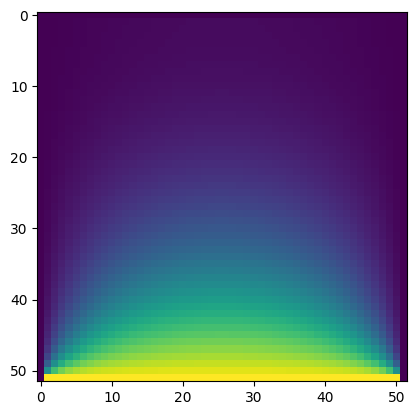

In [47]:
t = 99
cur_b = b[:,t]
g = unflatten_grid(cur_b)
plt.imshow(g)